<a href="https://colab.research.google.com/github/UralMan/RAG_service/blob/main/%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_RAG_%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оценка RAG-сервисов

## Зависимости

In [1]:
! pip install datasets torch accelerate bitsandbytes sentence-transformers pandas matplotlib

In [2]:
from google.colab import userdata

# Чтение токена из Secrets
hf_token = userdata.get("HF_TOKEN")

# Пример использования
from huggingface_hub import login
login(token=hf_token)

In [3]:
!pip install huggingface_hub

In [4]:
from huggingface_hub import login

# Способ 1: Через Secrets (Colab)
from google.colab import userdata
login(token=userdata.get("HF_TOKEN"))

In [5]:
from huggingface_hub import whoami

user_info = whoami()
print(f"Вы авторизованы как: {user_info['name']}")

Вы авторизованы как: Ura1Man


In [6]:
!pip install -U "bitsandbytes>=0.43.0"
!pip install transformers accelerate

In [7]:
!pip install ragas==0.1.5 sentence-transformers==2.6.1 transformers==4.40.2

In [47]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from ragas.metrics.base import Metric
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, Any, List
import numpy as np

## Метрики

In [48]:
class RussianAnswerRelevancy(Metric):
    name = "answer_relevancy"
    batch_size = 1
    evaluation_mode = "single"

    def __init__(self):
        super().__init__()
        self.embeddings = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

    def init(self): pass
    def adapt(self, lang="ru"): pass
    def _ascore(self, row): return self._score(row)

    def _score(self, row: Dict) -> float:
        q_embed = self.embeddings.encode(row["question"])
        a_embed = self.embeddings.encode(row["answer"])
        return cosine_similarity([q_embed], [a_embed])[0][0]

class RussianContextRecall(Metric):
    name = "context_recall"
    batch_size = 1
    evaluation_mode = "single"

    def __init__(self):
        super().__init__()
        self.embeddings = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

    def init(self): pass
    def adapt(self, lang="ru"): pass
    def _ascore(self, row): return self._score(row)

    def _score(self, row: Dict) -> float:
        gt = " ".join(row["ground_truths"][0])
        gt_embed = self.embeddings.encode(gt)
        ctx_embeds = self.embeddings.encode(row["contexts"])
        return np.max(cosine_similarity([gt_embed], ctx_embeds)[0])

class RussianContextPrecision(Metric):
    name = "context_precision"
    batch_size = 1
    evaluation_mode = "single"

    def __init__(self):
        super().__init__()
        self.embeddings = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

    def init(self): pass
    def adapt(self, lang="ru"): pass
    def _ascore(self, row): return self._score(row)

    def _score(self, row: Dict) -> float:
        question = row["question"]
        contexts = row["contexts"]
        q_embed = self.embeddings.encode(question)
        c_embeds = self.embeddings.encode(contexts)
        return np.mean(cosine_similarity([q_embed], c_embeds)[0])

class RussianAnswerCorrectness(Metric):
    name = "answer_correctness"
    batch_size = 1
    evaluation_mode = "single"

    def __init__(self):
        super().__init__()
        self.embeddings = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

    def init(self): pass
    def adapt(self, lang="ru"): pass
    def _ascore(self, row): return self._score(row)

    def _score(self, row: Dict) -> float:
        gt = " ".join(row["ground_truths"][0])
        a_embed = self.embeddings.encode(row["answer"])
        gt_embed = self.embeddings.encode(gt)
        return cosine_similarity([a_embed], [gt_embed])[0][0]

## Подготовка данных

In [49]:
examples = [
    {
        "question": "Какие основные слои атмосферы Земли?",
        "contexts": ["Атмосфера Земли состоит из тропосферы, стратосферы, мезосферы, термосферы и экзосферы."],
        "ground_truths": [["Тропосфера, стратосфера, мезосфера, термосфера, экзосфера"]]
    },
    {
        "question": "Кто написал роман 'Мастер и Маргарита'?",
        "contexts": ["Роман 'Мастер и Маргарита' был создан Михаилом Булгаковым в 1928-1940 годах."],
        "ground_truths": [["Михаил Афанасьевич Булгаков"]]
    },
    {
        "question": "Что такое теория относительности?",
        "contexts": ["Теория, разработанная Эйнштейном, описывающая законы физики в неинерциальных системах отсчёта."],
        "ground_truths": [["Физическая теория пространства-времени, разработанная Альбертом Эйнштейном"]]
    },
    {
        "question": "Назовите столицу Австралии",
        "contexts": ["Столицей Австралии является Канберра, специально построенный город для размещения правительства."],
        "ground_truths": [["Канберра"]]
    },
    {
        "question": "Как происходит процесс фотосинтеза?",
        "contexts": ["Растения преобразуют углекислый газ и воду в глюкозу с использованием солнечной энергии."],
        "ground_truths": [["Поглощение света хлорофиллом, преобразование CO₂ и воды в глюкозу с выделением кислорода"]]
    },
    {
        "question": "Что такое блокчейн?",
        "contexts": ["Технология распределенного реестра для записи транзакций в неизменяемой цепочке блоков."],
        "ground_truths": [["Децентрализованная система хранения данных в виде цепочки блоков"]]
    },
    {
        "question": "Кто был первым человеком в космосе?",
        "contexts": ["Юрий Гагарин совершил первый космический полёт 12 апреля 1961 года на корабле 'Восток-1'."],
        "ground_truths": [["Юрий Алексеевич Гагарин"]]
    },
    {
        "question": "Что такое искусственный интеллект?",
        "contexts": ["Технология создания систем, способных выполнять задачи, требующие человеческого интеллекта."],
        "ground_truths": [["Научное направление в разработке компьютерных систем, имитирующих когнитивные функции человека"]]
    },
    {
        "question": "Какие основные компоненты клетки?",
        "contexts": ["Клетка содержит ядро, цитоплазму, мембрану, митохондрии и рибосомы."],
        "ground_truths": [["Ядро, цитоплазма, клеточная мембрана, митохондрии, рибосомы"]]
    },
    {
        "question": "Что такое Великая Китайская стена?",
        "contexts": ["Крупнейший памятник архитектуры, система укреплений длиной 21 196 км, построенная для защиты от кочевников."],
        "ground_truths": [["Крупнейшее оборонительное сооружение в истории человечества, построенное в Древнем Китае"]]
    }
]

## Генерация ответов

In [50]:
model_name = "sberbank-ai/rugpt3medium_based_on_gpt2"
# model_name = "IlyaGusev/saiga_llama3_8b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer,
                    max_new_tokens=100, do_sample=True, temperature=0.3)

def generate_answer(question):
    response = generator(f"Ответь кратко: {question}\nОтвет:", return_full_text=False)[0]['generated_text']
    return response.split("Ответ:")[-1].strip()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Создание датасета

In [51]:
dataset = Dataset.from_dict({
    "question": [ex["question"] for ex in examples],
    "answer": [generate_answer(ex["question"]) for ex in examples],
    "contexts": [ex["contexts"] for ex in examples],
    "ground_truths": [ex["ground_truths"][0] for ex in examples]
})

## Вычисление метрик

In [52]:
metrics = [
    RussianAnswerRelevancy(),
    RussianContextPrecision(),
    RussianContextRecall(),
    RussianAnswerCorrectness()
]

results = []
for row in dataset:
    scores = {metric.name: metric._score(row) for metric in metrics}
    results.append(scores)

df = pd.DataFrame(results)

## Визуализация

### Модель `sberbank-ai/rugpt3medium_based_on_gpt2`

In [54]:
df["F1_score"] = 2*df["context_precision"]*df["context_recall"]/(df["context_precision"]+df["context_recall"])

In [72]:
df = df[['answer_relevancy', 'answer_correctness', 'context_precision', 'context_recall', 'F1_score']]

In [73]:
df.round(3)

,answer_relevancy,answer_correctness,context_precision,context_recall,F1_score
0,0.794,0.179,0.755,0.173,0.282
1,0.174,0.179,0.605,0.251,0.355
2,0.376,0.363,0.637,0.145,0.236
3,0.820,0.231,0.763,0.098,0.173
4,0.784,0.086,0.576,0.004,0.007
5,0.353,0.103,0.539,0.057,0.104
6,0.238,0.230,0.520,0.216,0.305
7,0.685,0.280,0.578,0.276,0.373
8,0.464,0.160,0.743,0.171,0.278
9,0.630,0.193,0.532,0.072,0.128


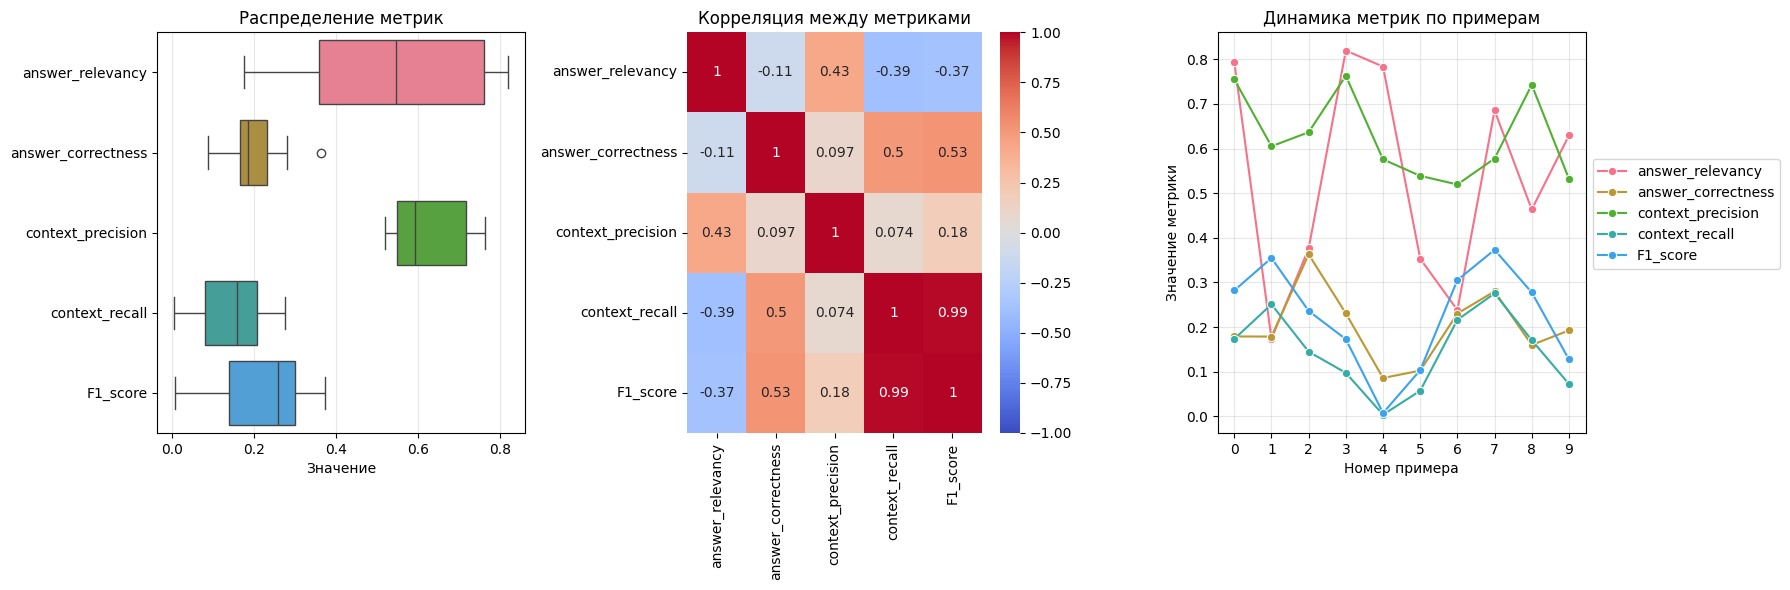

In [74]:
plt.figure(figsize=(18, 6))

# Распределение метрик
plt.subplot(1, 3, 1)
sns.boxplot(data=df, orient='h')
plt.title('Распределение метрик')
plt.xlabel('Значение')
plt.grid(axis='x', alpha=0.3)

# Тепловая карта корреляций
plt.subplot(1, 3, 2)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция между метриками')

# Сравнение по примерам
plt.subplot(1, 3, 3)
sns.lineplot(data=df, dashes=False, marker='o')
plt.title('Динамика метрик по примерам')
plt.xlabel('Номер примера')
plt.ylabel('Значение метрики')
plt.xticks(range(10))
plt.grid(alpha=0.3)
plt.legend(loc="upper left", bbox_to_anchor=(1,0.7))

plt.tight_layout()
plt.show()

# Резюме  
1. **Метрики основаны на RAGas:**   
    - Изначально планировалось использовать RAGas напрямую, но из-за проблем с зависимостью от OpenAI API пришлось реализовать *кастомные* метрики.   
    - Основные идеи (например, оценка релевантности через косинусную схожесть) были взяты из концепции RAGas, но адаптированы под локальные русскоязычные модели.   
2. **Реализованные метрики**:   

|Метрика |                                                                          Описание |                                                                                  Реализация |
    |:-----------------------|:----------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------|
    |   **Answer Relevancy** |                                             Соответствие ответа исходному вопросу | Косинусная схожесть эмбеддингов вопроса и ответа |
    | **Answer Correctness** |                                              Точность ответа относительно эталона | Схожесть ответа с ground truth |
    |  **Context Precision** |                                        Релевантность найденного контекста вопросу | Средняя схожесть контекста с вопросом |
    |     **Context Recall** |                                            Полнота релевантного контекста |  Максимальная схожесть эталона с контекстом |
    |  **F1-Score** |                                                      Баланс между точностью и полнотой | Среднее гармоническое между Precision и Recall. |


3. **Особенности реализации**:   
    - Использованы **мультиязычные эмбеддинги** ( `paraphrase-multilingual-mpnet-base-v2`) вместо OpenAI.   
    - Для генерации ответов применена локальная модель **rugpt3medium**.   
    - Все вычисления выполняются **без внешних API**, что обеспечивает полную независимость.   
   
### Почему не удалось использовать RAGas напрямую:   
- **Проблема 1**: Многие метрики RAGas требуют OpenAI API (например, `faithfulness`, `answer_similarity`).   
- **Проблема 2**: Ограниченная поддержка русского языка в стандартных метриках (например, морфология, порядок слов).   
- **Проблема 3**: Ошибки при интеграции с Hugging Face моделями (например, конфликты версий).   
   
## Вывод   
Система оценки получилась гибридной — на основе RAGas сделана кастомная реализация под русский язык. Это позволило сохранить логику оценки, но избежать зависимостей от OpenAI API.   
